# Line plot

Comparison of sorting algorithms including **bubble sort**, **merge sort** and **built-in python sort**

In [1]:
import time
import random
import matplotlib.pyplot as plt

In [2]:
def benchmark(func):
    """This decorator replaces function output with it's computation time"""
    def function(*args, **kwargs):
        start = time.time()
        func(*args, **kwargs)
        return time.time() - start
    return function


@benchmark
def bubble_sort(array):
    n = len(array)
    for i in range(n):
        already_sorted = True
        for j in range(n - i - 1):
            if array[j] > array[j + 1]:
                array[j], array[j + 1] = array[j + 1], array[j]
                already_sorted = False
        if already_sorted:
            break
    return array


@benchmark
def merge_sort_wrap(array):
    """Wrap to avoid recursive function decoration"""
    # Nested function definitions are needed to avoid usage of global namespace
    def merge_sort(array):
        def merge(left, right):
            if len(left) == 0:
                return right
            if len(right) == 0:
                return left
            result = []
            index_left = index_right = 0
            while len(result) < len(left) + len(right):
                if left[index_left] <= right[index_right]:
                    result.append(left[index_left])
                    index_left += 1
                else:
                    result.append(right[index_right])
                    index_right += 1
                if index_right == len(right):
                    result += left[index_left:]
                    break
                if index_left == len(left):
                    result += right[index_right:]
                    break
            return result

        if len(array) < 2:
            return array
        midpoint = len(array) // 2
        return merge(left=merge_sort(array[:midpoint]), right=merge_sort(array[midpoint:]))
    return merge_sort(array)

sorted_bench = benchmark(sorted)

In [3]:
bubble_times = []
merge_times = []
builtin_times = []
for sequence_len in range(2, 3003, 50):
    sample_seq = [random.randint(0, 10e6) for _ in range(sequence_len)]
    
    bubble_times.append(bubble_sort(sample_seq))
    merge_times.append(merge_sort_wrap(sample_seq))
    builtin_times.append(sorted_bench(sample_seq))

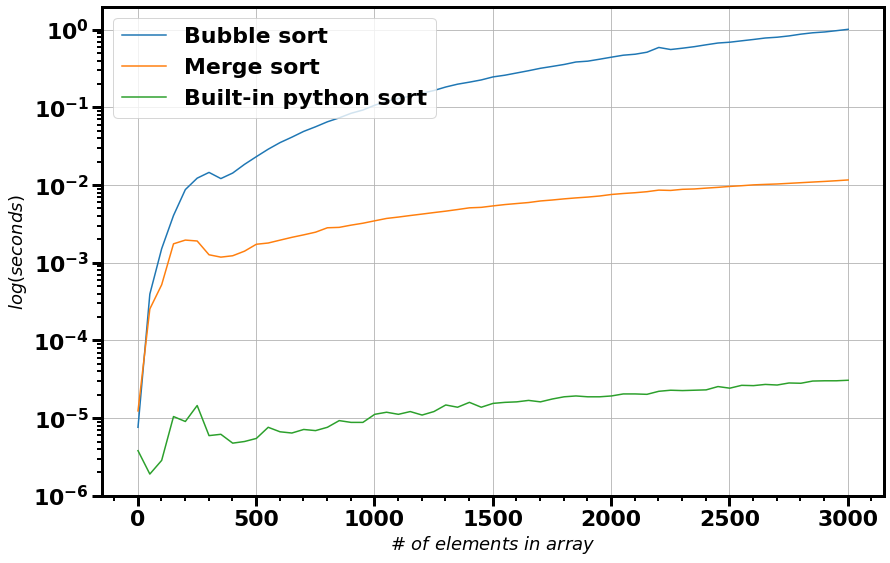

In [18]:
plt.rc("figure", figsize=(14, 9))
plt.plot(range(2, 3003, 50), bubble_times, label="Bubble sort")
plt.plot(range(2, 3003, 50), merge_times, label="Merge sort")
plt.plot(range(2, 3003, 50), builtin_times, label="Built-in python sort")
plt.xlabel("$\#\ of\ elements\ in\ array$", size=18)
plt.ylabel("$log(seconds)$", size=18)
plt.yscale("log")
plt.grid()
plt.legend(loc="upper left")

# Fasta sequence length distribution

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
def parse_fasta(filename):
    """
    Generator that yields fasta_id and sequence from fasta file.
    Bio.SeqIO.parse(...) from biopython may be used as an alternative
    """
    current_id = ""
    string = []
    with open(filename) as file_in:
        # Read lines from file until line is an empty string
        while line := file_in.readline().strip():
            if line.startswith(">"):
                if string:
                    yield current_id, "".join(string)
                    string = []
                current_id = line.lstrip(">")
            else:
                string.append(line)
        yield current_id, "".join(string)


filename = input("Enter path to fasta file: ")
sequence_lenghts = []
for _, sequence in parse_fasta(filename):
    sequence_lenghts.append(len(sequence))

plt.rc("figure", figsize=(17, 9))
sns.histplot(data=sequence_lenghts, kde=True, bins=len(sequence_lenghts)//40)
plt.xlabel("Sequence length")

Enter path to fasta file:  


FileNotFoundError: [Errno 2] No such file or directory: ''

# Volcano plot

Pre-processed RNAseq data on healthy tissue and tumor

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [26]:
data = pd.read_csv("data/volcano_data.csv", index_col=0)

In [27]:
# Subset 2 most up/down regulated genes
top_fc_down = data.query('logFC < 0 and pval_corr < 0.05').sort_values('logFC', ascending=True).head(2)
top_fc_up = data.query('logFC > 0 and pval_corr < 0.05').sort_values('logFC', ascending=False).head(2)
groups = {'Significantly downregulated': data.query('logFC < 0 and pval_corr < 0.05'),
          'Significantly upregulated': data.query('logFC > 0 and pval_corr < 0.05'),
          'Non-significantly downregulated': data.query('logFC < 0 and pval_corr > 0.05'),
          'Non-significantly upregulated': data.query('logFC > 0 and pval_corr > 0.05')}

In [28]:
# Define default plot parameters
plt.rc('figure', figsize=(25, 15))
plt.rc('font', size=22, weight='bold', style='normal')
plt.rc('xtick.minor', visible=True, size=5, width=2)
plt.rc('xtick.major', size=10, width=3)
plt.rc('ytick.minor', visible=True, size=5, width=2)
plt.rc('ytick.major', size=10, width=3)
plt.rc('axes', linewidth=3, labelsize=30, labelweight='bold', titlesize=48, titlepad=30, titleweight='bold')

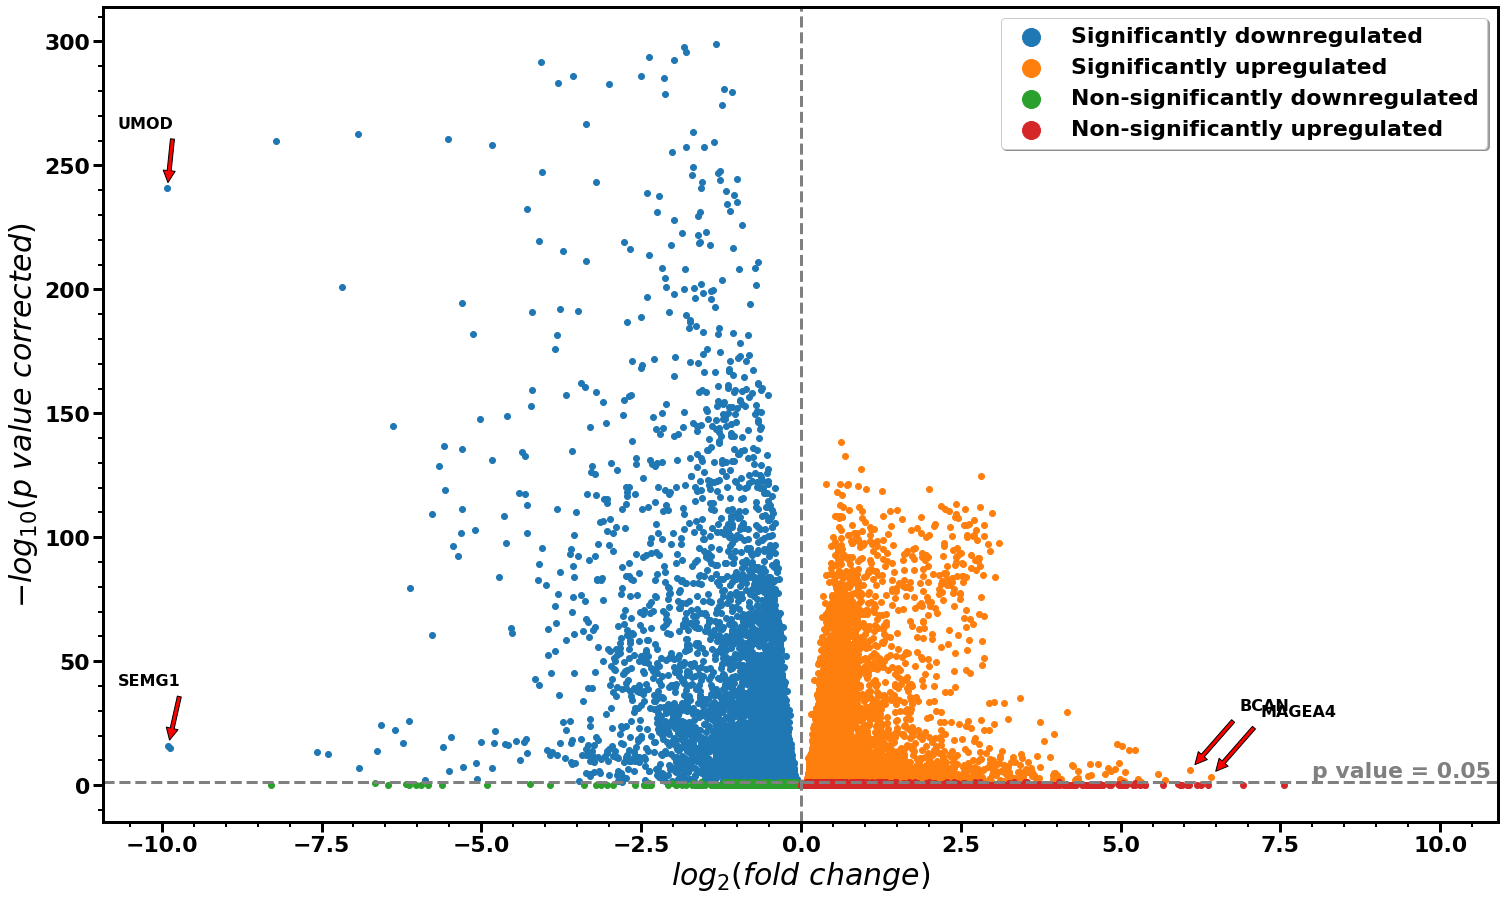

In [30]:
# Horizontal line (p_value = 0.05)
plt.axhline(-np.log10(0.05), linestyle='--', color='gray', linewidth=3)
# Vertical line (logFC = 0)
plt.axvline(0, linestyle='--', color='gray', linewidth=3)
# Horizontal line annotation (best position is hardcoded)
plt.text(8, -np.log10(0.001), 'p value = 0.05', color='gray')

# Each group is drawn separately
for group, dat in groups.items():  
    plt.scatter('logFC', 'log_pval', data=dat, label=group)

# Annotation of top downregulated genes
for gene, values in top_fc_down.iterrows():
    plt.annotate(xy=(values['logFC'], values['log_pval']),        # Point position (x, y)
                 xytext=(-50, 60), text=gene,                     # Point offset (x, y) and text
                 textcoords='offset points', fontsize=16,         # Offset type and font size
                 arrowprops=dict(width=4.0, facecolor='red',      # Arrow parameters: width, color, edgecolor
                                 edgecolor='k', shrink=0.1))      # "Shrink" is something like width/length

# Annotation of top upregulated genes
for gene, values in top_fc_up.iterrows():
    plt.annotate(xy=(values['logFC'], values['log_pval']),
                 xytext=(50, 60), text=gene,
                 textcoords='offset points', fontsize=16,
                 arrowprops=dict(width=4.0, facecolor='red',
                                 edgecolor='k', shrink=0.1))
    
plt.xlabel('$log_2(fold\ change)$')
plt.ylabel('$-log_{10}(p\ value\ corrected)$')
# Limit x axis for better view
plt.gca().set_xlim([-max(abs(data['logFC']))-1, max(abs(data['logFC']))+1])
plt.legend(markerscale=3, shadow=True)

# Annotated pie-chart with bar

![](images/Pie-bar-chart.svg)

Inspired by [this](https://matplotlib.org/gallery/pie_and_polar_charts/bar_of_pie.html#sphx-glr-gallery-pie-and-polar-charts-bar-of-pie-py) and [this](https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html?highlight=annotated%20pie%20chart)

Two parts of chart are assumed to be drawn separately and then to be joined in external editor.

It is possible to join them using plt functionality (like [here](https://matplotlib.org/gallery/pie_and_polar_charts/bar_of_pie.html#sphx-glr-gallery-pie-and-polar-charts-bar-of-pie-py)), but this will make code much more complicated.

In [31]:
import matplotlib.pyplot as plt
import ipywidgets
import numpy as np
import pandas as pd

In [32]:
# Load data which have two fields: "group name" and "number of samples in this group"
pie_data = pd.read_csv("data/piechart_data.csv", names=["smpl", "cnt"], skiprows=1)      
bar_data = pd.read_csv("data/piechart_data_bar.csv", names=["smpl", "cnt"], skiprows=1) 

## Static example

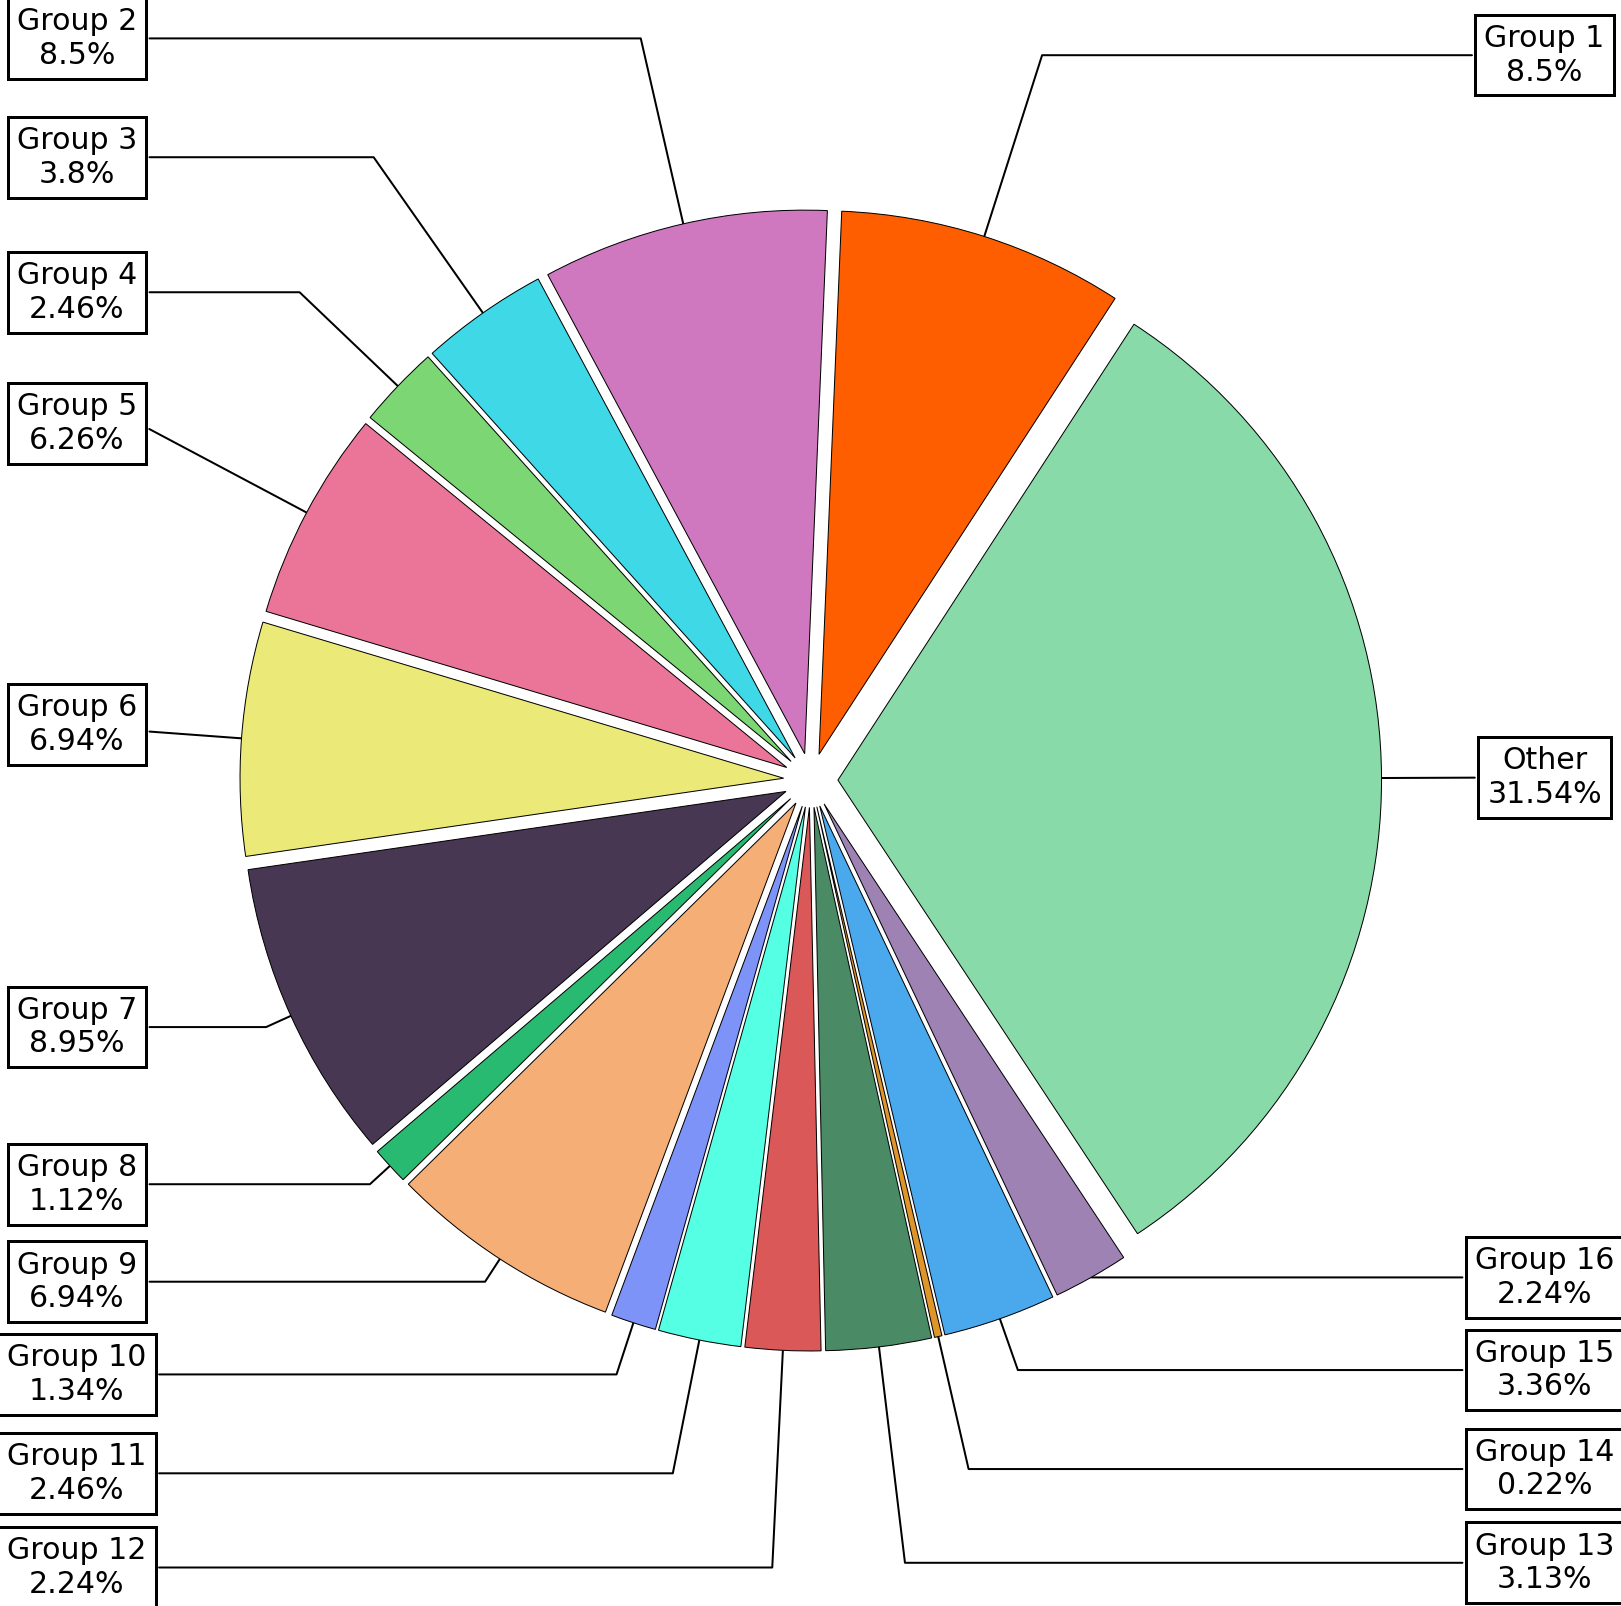

In [34]:
# Define default plot parameters
plt.rc('font', size=30)
plt.rc('figure', figsize=(25, 25))
plt.rc('font', weight="normal")

# Define custom colors or use default scheme
colors = ('#ff5e00', '#cf78c0', '#3ed8e7', '#7cd674', '#eb7598', '#ebe978',
          '#483752', '#29ba72','#f5af76', '#7e93f7', '#54ffe3', '#db5858',
          '#4a8a64', '#de962a', '#4aa9ed', '#9e82b3', '#88dba8')

# Parameters of text box
bbox_props = dict(boxstyle="square,pad=0.3", # Box style (https://matplotlib.org/3.1.1/tutorials/text/annotations.html#plotting-guide-annotation)
                  fc="w",                    # Foreground color
                  ec="k",                    # Edge color
                  lw=3)                      # Line width
# Arrow parameters
arrowprops=dict(arrowstyle="-", lw=2)
# Almost complete annotation parameters
kw = dict(arrowprops=arrowprops,
          bbox=bbox_props,
          zorder=0,                          # Defines drawing order when superposed
          va="center")                       # Vertical alignment

fig, ax = plt.subplots()

# Pie chart itself
wedges, texts = ax.pie('cnt', data=pie_data,
                       explode=[0.05 for _ in range(len(pie_data))],        # Relative distance of pie piece from center
                       startangle=57, colors=colors,
                       wedgeprops={'edgecolor': 'black', 'linewidth': 1})   # Wedge drawing parameters

# Vertical offsets for box position (very hard to pick manually)
y_offsets = [1.4, 1.4, 1.4, 1.3, 1.4, 1.4, 1.1, 1.1, 1.1, 1.15, 1.3, 1.45, 1.45, 1.3, 1.15, 1.05, 1.4]

for i, (wedge, yof) in enumerate(zip(wedges, y_offsets)):
    label = pie_data.smpl[i]                                             # Wedge label taken from dataframe
    value = pie_data.cnt[i]                                              # Count of sample taken from dataframe
    percent = str(round(value/pie_data.cnt.sum()*100, 2)) + '%'          # Count as percentage (optional)

    ang = (wedge.theta2 - wedge.theta1)/2. + wedge.theta1                # Angle corresponds to center of the wedge
    y = np.sin(np.deg2rad(ang))                                          # Degrees to radians (polar coordinates)
    x = np.cos(np.deg2rad(ang))
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)             # Defines connector bend
    kw["arrowprops"].update({"connectionstyle": connectionstyle})        
    # Draws all annotations
    ax.annotate(f'{pie_data.smpl[i]}\n{percent}',                        # Annotation text               
                xy=(x, y), xytext=(1.35*np.sign(x), yof*y),              # Box position
                horizontalalignment="center", **kw)

## Interactive example

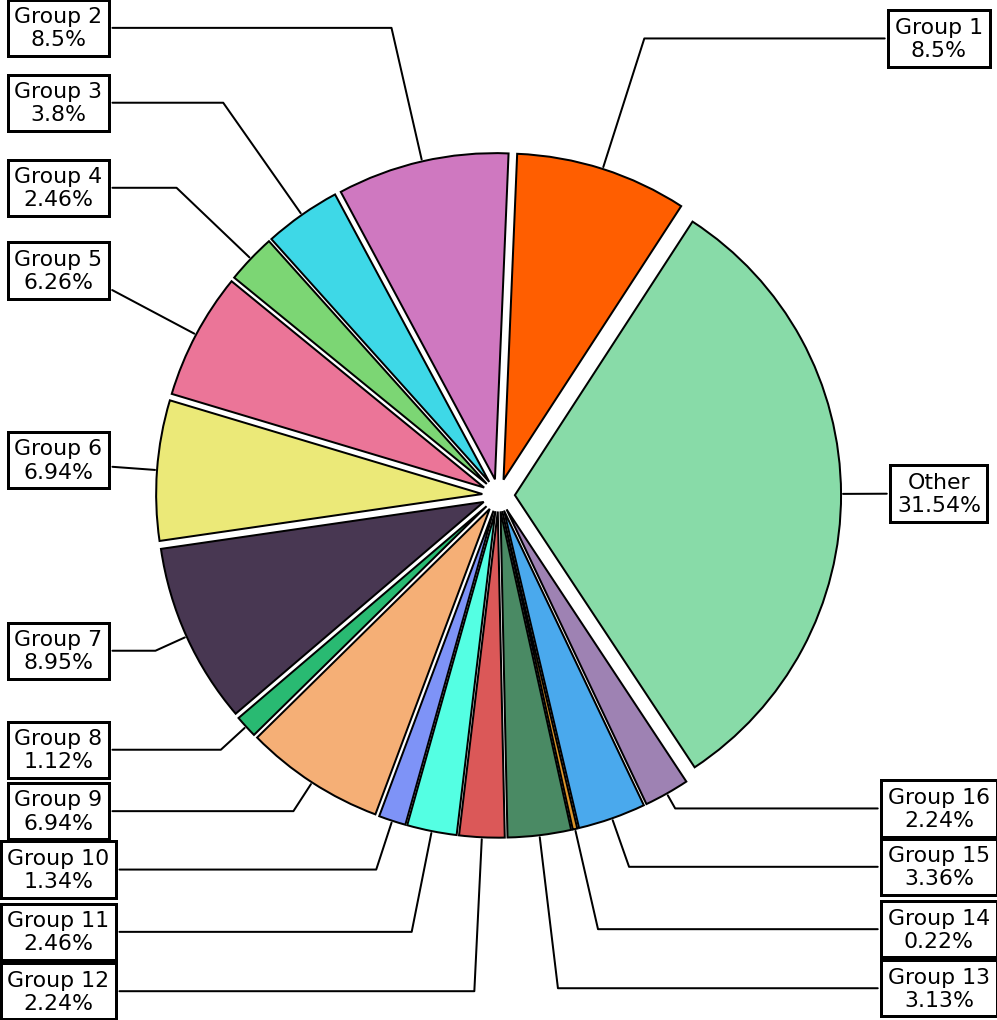

In [4]:
y_offsets = [1.4, 1.4, 1.4, 1.3, 1.4, 1.4, 1.1, 1.1, 1.1, 1.15, 1.3, 1.45, 1.45, 1.3, 1.15, 1.05, 1.4]
style = {'description_width': 'initial'}
widgets = dict(figsize_x=ipywidgets.IntSlider(min=5, max=30, step=1, value=15),
                     figsize_y=ipywidgets.IntSlider(min=5, max=30, step=1, value=15),
                     font_size=ipywidgets.IntSlider(min=4, max=40, step=2, value=22),
                     box_fg=ipywidgets.Dropdown(options=['white', 'blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']),
                     box_edge=ipywidgets.Dropdown(options=['black', 'white', 'blue', 'green', 'red', 'cyan', 'magenta', 'yellow']),
                     box_lw=ipywidgets.FloatSlider(min=1, max=10, step=0.5, value=3),
                     arrow_style=ipywidgets.Dropdown(options=["-", "->", "-[", "-|>", "<-", "<->", "<|-", "<|-|>", "]-", "]-[", "|-|"]),
                     arrow_lw=ipywidgets.FloatSlider(min=1, max=10, step=0.5, value=2),
                     explode=ipywidgets.FloatSlider(min=0, max=1, step=0.01, value=0.05),
                     start_angle=ipywidgets.IntSlider(min=0, max=360, step=1, value=57),
                     percentage=True,
                     edge_color=ipywidgets.Dropdown(options=['black', 'white', 'blue', 'green', 'red', 'cyan', 'magenta', 'yellow']),
                     edge_lw=ipywidgets.FloatSlider(min=1, max=10, step=0.5, value=2),
                     box_x_offset=ipywidgets.FloatSlider(min=1, max=2, step=0.05, value=1.35))
box_y_offset_widgets = dict(zip(pie_data.smpl.apply(lambda x: x + "_y_offset"),
                                [ipywidgets.FloatSlider(min=0.8, max=1.6, step=0.01, value=y_offsets[i], style=style) for i in range(len(pie_data))]))

@ipywidgets.interact(**widgets, **box_y_offset_widgets)
def draw_piechart(**kwargs):
    # Define default plot parameters
    plt.rc('axes')
    plt.rc('figure')
    plt.rc('font', size=kwargs["font_size"])
    plt.rc('figure', figsize=(kwargs["figsize_x"], kwargs["figsize_y"]))

    # Define custom colors or use default scheme
    colors = ('#ff5e00', '#cf78c0', '#3ed8e7', '#7cd674', '#eb7598', '#ebe978',
              '#483752', '#29ba72','#f5af76', '#7e93f7', '#54ffe3', '#db5858',
              '#4a8a64', '#de962a', '#4aa9ed', '#9e82b3', '#88dba8')

    # Parameters of text box
    bbox_props = dict(boxstyle="square,pad=0.3",                # Box style (https://matplotlib.org/3.1.1/tutorials/text/annotations.html#plotting-guide-annotation)
                      fc=kwargs["box_fg"],                      # Foreground color
                      ec=kwargs["box_edge"],                    # Edge color
                      lw=kwargs["box_lw"])                      # Line width
    # Arrow parameters
    arrowprops=dict(arrowstyle=kwargs["arrow_style"], lw=kwargs["arrow_lw"])
    # Almost complete annotation parameters
    kw = dict(arrowprops=arrowprops,
              bbox=bbox_props,
              zorder=0,                          # Defines drawing order when superposed
              va="center")                       # Vertical alignment

    fig, ax = plt.subplots()

    # Pie chart itself
    wedges, texts = ax.pie('cnt', data=pie_data,
                           explode=[kwargs["explode"] for _ in range(len(pie_data))],        # Relative distance of pie piece from center
                           startangle=kwargs["start_angle"], colors=colors,
                           wedgeprops={'edgecolor': kwargs["edge_color"], 'linewidth': kwargs["edge_lw"]})   # Wedge drawing parameters


    for i, wedge in enumerate(wedges):
        label = pie_data.smpl[i]                                             # Wedge label taken from dataframe
        value = pie_data.cnt[i]                                              # Count of sample taken from dataframe
        if kwargs["percentage"]:
            value = str(round(value/pie_data.cnt.sum()*100, 2)) + '%'          # Count as percentage (optional)

        ang = (wedge.theta2 - wedge.theta1)/2. + wedge.theta1                # Angle corresponds to center of the wedge
        y = (1 + kwargs["explode"]) * np.sin(np.deg2rad(ang))                # Degrees to radians (polar coordinates) 1 + explode is radius
        x = (1 + kwargs["explode"]) * np.cos(np.deg2rad(ang))
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)             # Defines connector bend
        kw["arrowprops"].update({"connectionstyle": connectionstyle})        
        # Draws all annotations
        ax.annotate(f'{pie_data.smpl[i]}\n{value}',                        # Annotation text               
                    xy=(x, y), xytext=(kwargs["box_x_offset"]*np.sign(x), kwargs[label + "_y_offset"] * y),                # Box position
                    horizontalalignment="center", **kw)


## Bar

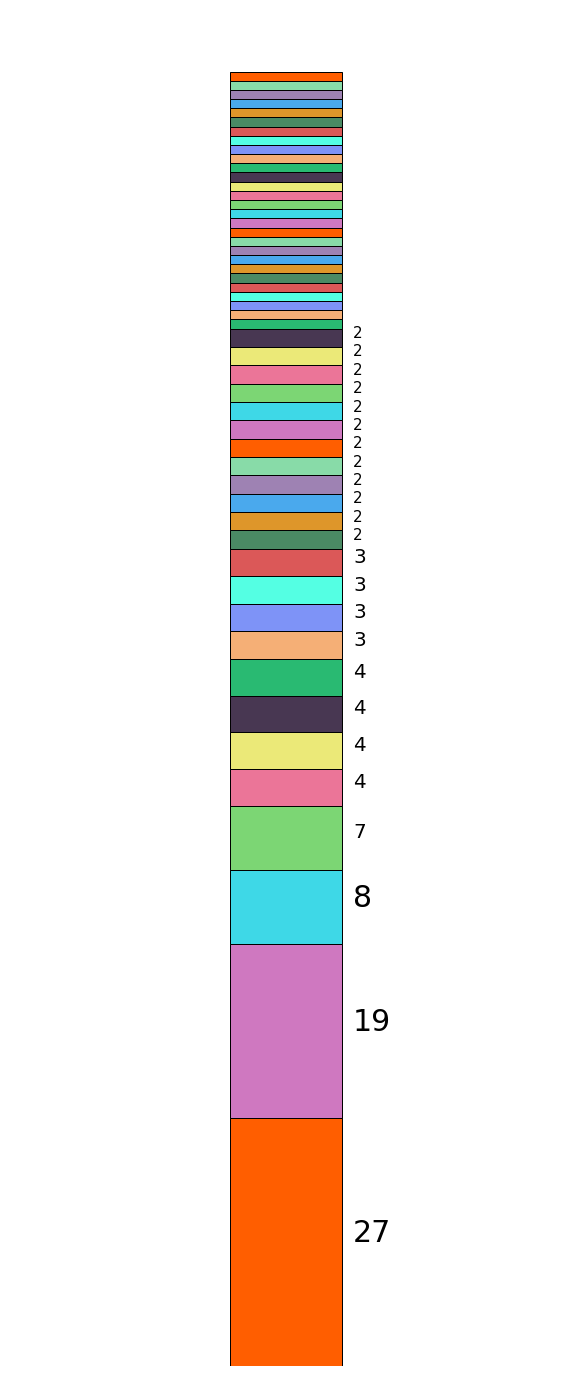

In [35]:
# Expand color palette to cover all samples
colors = colors * 10
ratios = sorted([(i/bar_data.cnt.sum(), i) for i, p in zip(bar_data.cnt, bar_data.smpl)], key=lambda x: x[0], reverse=True)
bottom = 0
width = 0.05
plt.rc("figure", figsize=(10, 25))
fig, ax = plt.subplots()
# Whole bar is actually stack of many bars
for j in range(len(ratios)):
    # Height of single bar (ratio)
    height = ratios[j][0]
    ax.bar(0, height, width, bottom=bottom, edgecolor='black', color=colors[j])
    ypos = bottom + ax.patches[j].get_height() / 2    # y position for text placement
    bottom += height      
    if ratios[j][1] >= 8:            # Decrease font size with small bars
        plt.rc('font', size=30)
    elif 8 > ratios[j][1] >= 3:
        plt.rc('font', size=20)
    else:
        plt.rc('font', size=15)
    if ratios[j][1] != 1:            # Ignore text on single sample bars
        ax.text(.03, ypos, ratios[j][1],
                 ha='left')
ax.axis('off')
ax.set_xlim(- 2.5 * width, 2.5 * width)